In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_lorenz_96
from models.crnn import cRNN, train_model_ista

In [2]:
import pandas as pd

In [3]:
# For GPU acceleration
device = torch.device('cuda')

In [4]:
# Simulate data
#X_np, GC = simulate_lorenz_96(p=10, F=10, T=1000)
#X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)

In [5]:
wt = pd.read_csv("weather2024.csv")

In [6]:
wt

,일시,기온,강수량,풍속,습도,일사
0,2024-01-01 01:00,3.8,0.0,1.5,80,0.0
1,2024-01-01 02:00,3.9,0.0,0.2,79,0.0
2,2024-01-01 03:00,3.5,0.0,0.4,84,0.0
3,2024-01-01 04:00,1.9,0.0,1.1,92,0.0
4,2024-01-01 05:00,1.4,0.0,1.5,94,0.0
...,...,...,...,...,...,...
8755,2024-12-30 20:00,7.6,0.0,1.4,71,0.0
8756,2024-12-30 21:00,7.5,0.0,1.7,69,0.0
8757,2024-12-30 22:00,7.2,0.0,1.2,70,0.0
8758,2024-12-30 23:00,7.2,0.0,1.7,71,0.0


In [7]:
from sklearn.preprocessing import StandardScaler

X_np = wt.iloc[:, 1:].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

X_np = X_scaled.astype(np.float32)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)

In [8]:
# Set up model
crnn = cRNN(X.shape[-1], hidden=100).cuda(device=device)

In [9]:
# Train with ISTA
train_loss_list = train_model_ista(
    crnn, X, context=10, lam=10.0, lam_ridge=1e-2, lr=1e-3, max_iter=20000,
    check_every=50)

----------Iter = 50----------
Loss = 5.275791
Variable usage = 100.00%
----------Iter = 100----------
Loss = 1.339803
Variable usage = 0.00%
----------Iter = 150----------
Loss = 1.338235
Variable usage = 0.00%
----------Iter = 200----------
Loss = 1.336950
Variable usage = 0.00%
----------Iter = 250----------
Loss = 1.335857
Variable usage = 0.00%
----------Iter = 300----------
Loss = 1.334898
Variable usage = 0.00%
----------Iter = 350----------
Loss = 1.334030
Variable usage = 0.00%
----------Iter = 400----------
Loss = 1.333226
Variable usage = 0.00%
----------Iter = 450----------
Loss = 1.332466
Variable usage = 0.00%
----------Iter = 500----------
Loss = 1.331737
Variable usage = 0.00%
----------Iter = 550----------
Loss = 1.331030
Variable usage = 0.00%
----------Iter = 600----------
Loss = 1.330338
Variable usage = 0.00%
----------Iter = 650----------
Loss = 1.329658
Variable usage = 0.00%
----------Iter = 700----------
Loss = 1.328985
Variable usage = 0.00%
----------Iter = 75

In [10]:
train_loss_np = np.array([loss.cpu().item() for loss in train_loss_list])

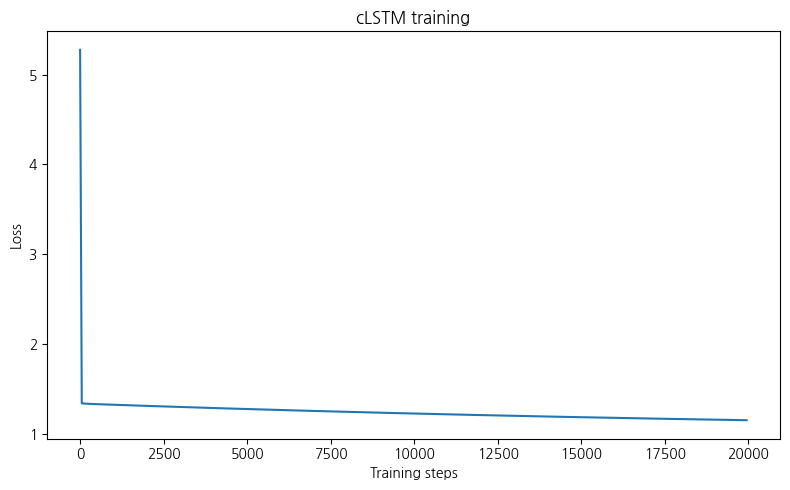

In [11]:
# Loss function plot
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_np)), train_loss_np)
plt.title('cLSTM training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

In [12]:
# 5개의 기상 변수 (기온, 강수량, 풍속, 습도, 일사)에 대한 GC 행렬
GC = np.array([[1, 1, 0, 0, 0],  # 기온 -> 강수량
               [0, 1, 1, 0, 0],  # 강수량 -> 풍속
               [0, 0, 1, 1, 0],  # 풍속 -> 습도
               [0, 0, 0, 1, 1],  # 습도 -> 일사
               [0, 0, 0, 0, 1]])  # 일사 -> 기온 (self loop)

True variable usage = 36.00%
Estimated variable usage = 0.00%
Accuracy = 64.00%


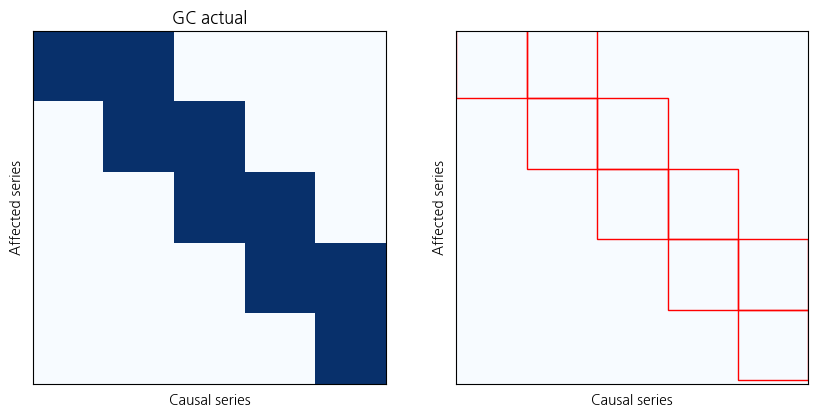

In [13]:
# Check learned Granger causality
GC_est = crnn.GC().cpu().data.numpy()

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()